#Overview


* This notebook was created in colab and meant to interface with our team's GCP Bucket (mounts). Link to colab notebook [here](https://drive.google.com/file/d/1GmVixIsCiJLqACfepLAC9mO-gr-Q9-m_/view?usp=sharing).
* Milestone versions of this notebook are in [github](https://github.com/dyeramosu/ac215_snapnutrition)
* This notebook has 2 sections 1) data exploration and 2) model building
* This beginning notebook also helped us to figure out what data we need and what needs to be pre-processed.


# Nutrition5k Dataset EDA



## Nutrition5K Paper DataSource Overview

*   Nurtiion5k paper had their data in a GCP bucket. They have a Google Bucket link [here](https://console.cloud.google.com/storage/browser/nutrition5k_dataset;tab=objects?prefix=&forceOnObjectsSortingFiltering=false)
*   Bucket size total of 181 GB (includes photos and 360-degree surround food videos)
*   Nutrition5k is a medium dataset (less than 2TB). It will not fit in RAM but maybe in local disk

1) First we'll need to extract the unique ID for each dish image. We will also need the corresponding nutrition info of each food image. The following csv's contain all nutrition metadata at the dish_id-level, as well as per-ingredient mass and macronutrients. The default directory structure is:

```
  └── nutrition5k_dataset
        └──metadata
           ├── dish_metadata_cafe1.csv
           └── dish_metadata_cafe2.csv
```
For each dish ID dish_[10 digit timestamp], there is a CSV entry containing the following fields:

```
dish_id, total_calories, total_mass, total_fat, total_carb, total_protein, num_ingrs,
(ingr_1_id, ingr_1_name, ingr_1_grams, ingr_1_calories, ingr_1_fat, ingr_1_carb, ingr_1_protein, ...)
with the last 8 fields are repeated for every ingredient present in the dish.
```
Note: There is a seperate CSV for each ingredient ID and their nutrition info at:

```
nutrition5k_dataset/nutrition5k_dataset/metadata/ingredients_metadata.csv
```

2) Second we'll need to extract the overhead shot of each image using dish_id. We will ognore the depth shots for each dish_id for now. The default directory structure we will look into is:

```
  └── nutrition5k_dataset
        └──imagery
            └── realsense_overhead
                 ├──dish_{ID}
                 │   ├── depth_color.png
                 │   ├── depth_raw.png
                 │   └── rbg.png
                 ├──dish_{ID}...
                 ...                  
```



## Mount Team SnapNutrition GCP Bucket To Colab

Instead of reading files directly from Nutrion5k's GCP bucket, we transferred a subset of the files of interest (excluding video files) into our own bucket for versioning.

From now on we will use our GCP bucket data source [direct link](https://console.cloud.google.com/storage/browser/snapnutrition_data_bucket?authuser=0&project=csci-115-398800&pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&prefix=&forceOnObjectsSortingFiltering=false)

In [38]:
#cell to connect to our GCP Bucket
from google.colab import auth

auth.authenticate_user()

#THIS WILL CREATE A GOOGLE POP-UP WINDOW TO LOGIN
#If you do not have access to our bucket, please message brent ruttle

In [39]:
!gcloud config set project csci-115-398800

Updated property [core/project].


Install package needed to mount GCP Bucket to colab

In [40]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  2659  100  2659    0     0  16101      0 --:--:-- --:--:-- --:--:-- 16018
OK
19 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: http://packages.cloud.google.com/apt/dists/gcsfuse-bionic/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
gcsfuse is already the newest version (1.2.0).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


Make a directory and mount GCP bucket "snapnutrition_data_bucket" to the folder

In [41]:
!mkdir snap_nutrition_data
!gcsfuse --implicit-dirs snapnutrition_data_bucket snap_nutrition_data
!gcsfuse --implicit-dirs snapnutrition_data_bucket/raw_data/Nutrition5k_realsense_overhead snap_nutrition_data/raw_data/Nutrition5k_realsense_overhead

#!chmod 777 -R snap_nutrition_data

mkdir: cannot create directory ‘snap_nutrition_data’: File exists
{"time":"26/09/2023 08:33:33.470938","severity":"INFO","msg":"Start gcsfuse/1.2.0 (Go version go1.21.0) for app \"\" using mount point: /content/snap_nutrition_data\n"}
{"time":"26/09/2023 08:33:33.768998","severity":"INFO","msg":"Start gcsfuse/1.2.0 (Go version go1.21.0) for app \"\" using mount point: /content/snap_nutrition_data/raw_data/Nutrition5k_realsense_overhead\n"}
daemonize.Run: readFromProcess: sub-process: mountWithArgs: mountWithStorageHandle: fs.NewServer: create file system: SetUpBucket: Error in iterating through objects: storage: bucket doesn't exist


##Exploratory Data Analysis (EDA)

In [42]:
import pandas as pd
from PIL import Image
import requests
from io import BytesIO
import tensorflow as tf
import os
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

AUTOTUNE = tf.data.AUTOTUNE
#constants for using the Nutrition5k Research Paper's Public Google Bucket
GOOGLE_BUCKET_DOMAIN = "https://storage.googleapis.com/"
DISH_IMAGES_DIRECTORY = "nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/"

In [43]:
#Step 1: Download and Read Dish ID and Nutrition Info CSV

#for now we only care about the first 6 columns, the rest of the columns have ingredients columns taking up varible # of columns
labels = pd.read_csv("snap_nutrition_data/raw_data/Nutrition5k_Other/dish_metadata_cafe1.csv", sep=',', header=None,  usecols=range(0,6), names=['dish_id', 'total_calories', 'total_mass', 'total_fat', 'total_carb', 'total_protein'])
labels.head()

,dish_id,total_calories,total_mass,total_fat,total_carb,total_protein
0,dish_1561662216,300.794281,193.0,12.387489,28.218290,18.633970
1,dish_1562688426,137.569992,88.0,8.256000,5.190000,10.297000
2,dish_1561662054,419.438782,292.0,23.838249,26.351543,25.910593
3,dish_1562008979,382.936646,290.0,22.224644,10.173570,35.345387
4,dish_1560455030,20.590000,103.0,0.148000,4.625000,0.956000


In [44]:
#let's look at the 2nd CSV of dishes
labels2 = pd.read_csv("snap_nutrition_data/raw_data/Nutrition5k_Other/dish_metadata_cafe2.csv", sep=',', header=None,  usecols=range(0,6), names=['dish_id', 'total_calories', 'total_mass', 'total_fat', 'total_carb', 'total_protein'])
labels2.head()

#why are these dishes 0 calories? let's pull up one image below

,dish_id,total_calories,total_mass,total_fat,total_carb,total_protein
0,dish_1572974428,0.0,74.0,0.0,0.0,0.0
1,dish_1572464692,0.0,56.0,0.0,0.0,0.0
2,dish_1571931594,0.0,66.0,0.0,0.0,0.0
3,dish_1575478635,0.0,132.0,0.0,0.0,0.0
4,dish_1572887017,0.0,274.0,0.0,0.0,0.0


In [45]:
#combine 2 csv's of dish id and nutrition from the 2 cafe's

full_labels_df = pd.concat([labels, labels2], axis=0, ignore_index=True)
full_labels_df.head()


,dish_id,total_calories,total_mass,total_fat,total_carb,total_protein
0,dish_1561662216,300.794281,193.0,12.387489,28.218290,18.633970
1,dish_1562688426,137.569992,88.0,8.256000,5.190000,10.297000
2,dish_1561662054,419.438782,292.0,23.838249,26.351543,25.910593
3,dish_1562008979,382.936646,290.0,22.224644,10.173570,35.345387
4,dish_1560455030,20.590000,103.0,0.148000,4.625000,0.956000


In [46]:
#Step 2: Download image corresponding to dish_id

#create url from dish_id
#specify rbg (normal photo), depth_raw, and depth_colored image of the dish
def create_image_url(dish_id, image_type='overhead_depth_rgb'):

  file = ''
  if image_type == "overhead_rgb":
    file = 'rgb.png'
  elif image_type == "overhead_depth_color":
    file = 'depth_color.png'
  elif image_type == "overhead_depth_raw":
    file = 'depth_raw.png'
  else:
    raise ValueError('create_image_url() image_type parameter passed not valid')

  url = GOOGLE_BUCKET_DOMAIN + DISH_IMAGES_DIRECTORY + dish_id + '/' + file

  return url

#preview purposes - download image given url
def view_image(url: str):
  #IPython.display.Image(url, width = 250)
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  return img

test url:  https://storage.googleapis.com/nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1572974428/rgb.png


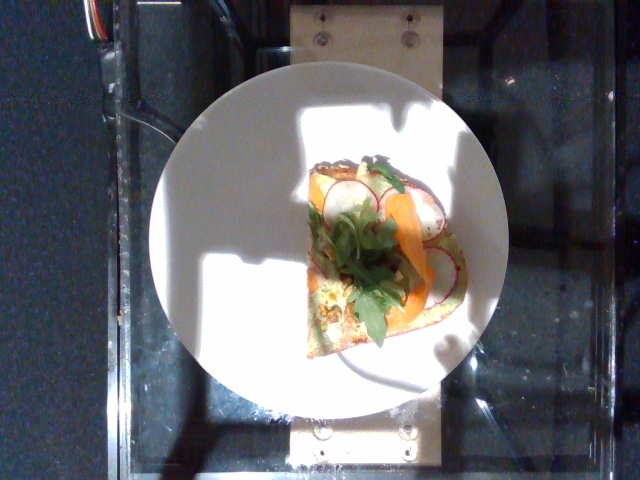

In [47]:
#test create_image_url function
test_url = create_image_url('dish_1572974428', "overhead_rgb")
print("test url: ", test_url)
#preview image
test_image = view_image(test_url)
test_image

#Note: @TODO this dish allegedly has 0 calories. Even if mostly veggies, still looks like it should have some

This allegedly 0 calorie dish does not look to be 0 calories. Let's check one more.

test url:  https://storage.googleapis.com/nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1574359199/rgb.png


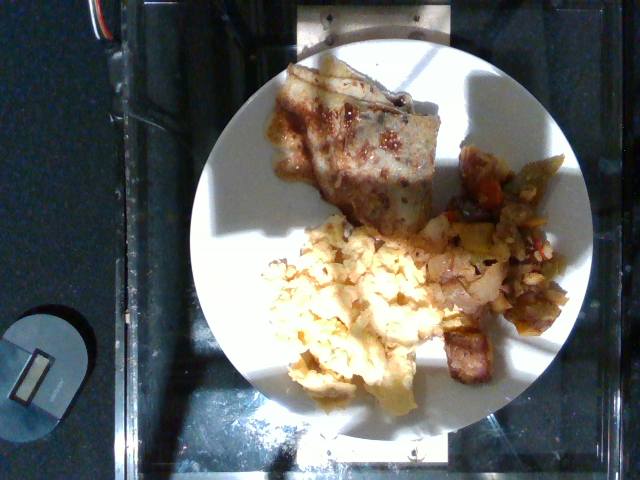

In [48]:
#test create_image_url function
test_url = create_image_url('dish_1574359199', "overhead_rgb")
print("test url: ", test_url)
#preview image
test_image = view_image(test_url)
test_image

Again this image obviously should not be labeled 0 calories. Looks like from the 2 test image above taken from dishes with 0 calories that they should NOT be 0 calories. Let's exclude these 0 calorie entries from the dataset.

In [49]:
#exclude bad entires from dataset
print("Total entries with 0 calories: ", full_labels_df[full_labels_df['total_calories']==0].shape[0])
print("Total entries in dataset: ", full_labels_df.shape[0])
print('Total good label entries in csv: ', full_labels_df.shape[0] - full_labels_df[full_labels_df['total_calories']==0].shape[0])

Total entries with 0 calories:  240
Total entries in dataset:  5006
Total good label entries in csv:  4766


In [50]:
#list of dish_id's with 0 calories (to be used in model input section)

issue_dish_id_array = full_labels_df[full_labels_df['total_calories']==0].dish_id.values

len(issue_dish_id_array)

240

In [51]:
#make sure dish_id's are unique and can be used to lookup image files

full_labels_df['dish_id'].is_unique

True

dish_id's are unique and can be used to map images to their corresponding label entry in the csv

In [52]:
#Check overall stats of dataframe excluding 0 calorie dishes

full_labels_df[full_labels_df['total_calories']!=0].describe()

,total_calories,total_mass,total_fat,total_carb,total_protein
count,4766.000000,4766.000000,4766.000000,4766.000000,4766.000000
mean,224.074826,191.491817,11.261491,17.859201,15.205472
std,312.615468,275.086565,24.942476,29.132718,18.729645
min,1.150000,5.000000,0.000000,0.000000,0.072000
25%,60.992498,72.000000,0.621500,5.129467,1.684543
50%,154.337662,145.000000,6.485808,12.718711,8.259263
75%,324.397980,260.000000,16.069001,24.200296,22.528633
max,9485.815430,7975.000000,875.541016,844.568604,147.491821


As a sanity check, let's look at the image with the lowest # of calories 1.150000

In [53]:
corrected_full_df = full_labels_df[full_labels_df['total_calories']!=0]
min_dish_id = corrected_full_df[corrected_full_df['total_calories'] == corrected_full_df['total_calories'].min()].dish_id.item()
print("dish with lowest calories: ", min_dish_id)
corrected_full_df[corrected_full_df['total_calories'] == corrected_full_df['total_calories'].min()]


dish with lowest calories:  dish_1558461431


,dish_id,total_calories,total_mass,total_fat,total_carb,total_protein
287,dish_1558461431,1.15,5.0,0.02,0.18,0.145


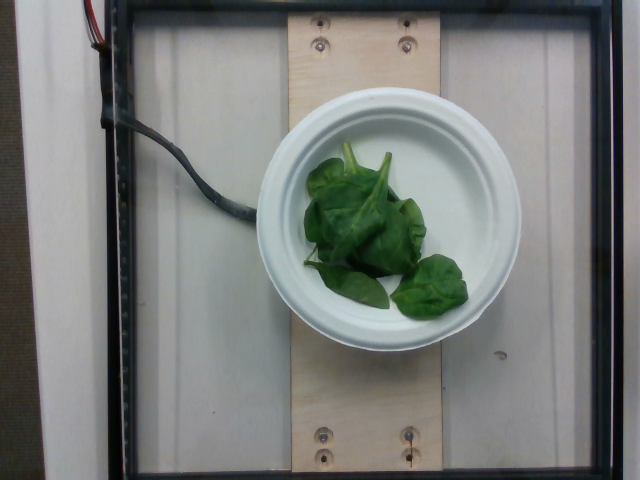

In [54]:
#view small calorie entry
test_url = create_image_url(min_dish_id, "overhead_rgb")
#preview image
test_image = view_image(test_url)
test_image

This low calorie entry makes sense. And entire bag of spinach I get at the groceries is 66 calories whereas here is a small handful.

In [55]:
#get dish in dataset with most calories

corrected_full_df[corrected_full_df['total_calories'] == corrected_full_df['total_calories'].max()]

,dish_id,total_calories,total_mass,total_fat,total_carb,total_protein
446,dish_1551567573,9485.81543,159.0,875.541016,506.078979,87.785004
565,dish_1551567604,9485.81543,159.0,875.541016,506.079010,87.785004


Here there are 2 identical entries tied for max calories. What are the photos?

**Answer:** These appear to be linked to food videos (not overhead pictures), so they are not part of the dataset we are interested in.

Note: these labels appear to be a slightly bigger set than food with overhead iamges. The paper did mention there are some foods with video entries only.

# Model Building

1. full_label_df connects unique dish_id's to the nutrition info
2. dish_id also corresponds to the image directory to get the regular png (we will exclude depth images for now)

**Model Input:** will be the overhead image png


**Model Output:** will be (total_calories, total_mass, total_fat, total_carb, total_protein)


Followed this tutorial for loading images via tensorflow https://www.tensorflow.org/tutorials/load_data/images

## Create Input for Tensorflow (image filepaths + labels)

In [56]:
data_dir = './snap_nutrition_data/raw_data/Nutrition5k_realsense_overhead'

#have to have preprocessed data in a Google Bucket for this to work
#ds_train, ds_test = tfds.load(name="test", split=["train", "test"], data_dir="gs://nutrition5k_dataset")

#get label for dish
def get_nutrition_from_dish_id(full_labels_df, dish_id):
    total_calories = full_labels_df[full_labels_df['dish_id']==dish_id]['total_calories'].item()
    total_mass = full_labels_df[full_labels_df['dish_id']==dish_id]['total_mass'].item()
    total_fat = full_labels_df[full_labels_df['dish_id']==dish_id]['total_fat'].item()
    total_carb = full_labels_df[full_labels_df['dish_id']==dish_id]['total_carb'].item()
    total_protein = full_labels_df[full_labels_df['dish_id']==dish_id]['total_protein'].item()

    return (total_calories, total_mass, total_fat, total_carb, total_protein)



In [57]:
#remove filepaths to images with 0 calories
issue_dish_id_array_filepaths = [dish_id for dish_id in issue_dish_id_array] #get issue dish id's with 0 calories
dish_ids_with_rgb = [fname for fname in os.listdir(data_dir)] #get all dishes with overhead images
valid_dish_ids = list(set(dish_ids_with_rgb)-set(issue_dish_id_array_filepaths)) #get only good dishes

print("Full number of images with overhead photos: ", len(dish_ids_with_rgb))
print("number of images without 0 calorie labels: ", len(valid_dish_ids))

#create image filepaths and labels
filenames = [os.path.join(data_dir, fname, 'rgb.png') for fname in valid_dish_ids]  #select rgb images only for now (exclude depth)
labels = [get_nutrition_from_dish_id(full_labels_df, fname) for fname in valid_dish_ids]
data_dict = {'filename': filenames, 'label': labels}
image_count = len(filenames)

Full number of images with overhead photos:  3490
number of images without 0 calorie labels:  3260


Not all labels have an overhead dish image (some may just be 360-pan videos). Notice that list of good images is less than # of non-zero calorie dish nutrition labels.

In [58]:
#create full dataset that will feed into tensorflow
list_ds = tf.data.Dataset.from_tensor_slices(data_dict)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

#preview paths
for f in list_ds.take(5):
  print(f['filename'].numpy())
  print(f['label'].numpy())

b'./snap_nutrition_data/raw_data/Nutrition5k_realsense_overhead/dish_1566332040/rgb.png'
[14.95  65.     0.26   2.34   1.885]
b'./snap_nutrition_data/raw_data/Nutrition5k_realsense_overhead/dish_1560889061/rgb.png'
[402.50766  281.        22.432436  13.32338   37.306126]
b'./snap_nutrition_data/raw_data/Nutrition5k_realsense_overhead/dish_1564432191/rgb.png'
[261.02838  220.        11.519486  32.14186    9.461219]
b'./snap_nutrition_data/raw_data/Nutrition5k_realsense_overhead/dish_1558639362/rgb.png'
[156.179    342.         1.42      37.420002   3.902   ]
b'./snap_nutrition_data/raw_data/Nutrition5k_realsense_overhead/dish_1558722685/rgb.png'
[25.84  76.     0.152  6.08   0.608]


In [59]:
#split dataset into train and validation sets
train_ds_size = int(0.70 * image_count)
valid_ds_size = int(0.15 * image_count)

#train will be 70%
train_ds = list_ds.take(train_ds_size)
remaining = list_ds.skip(train_ds_size)
#val will be 15%
val_ds = remaining.take(valid_ds_size)
#test will be 15%
test_ds = remaining.skip(valid_ds_size)

#print length of each
print("train split length: ", tf.data.experimental.cardinality(train_ds).numpy())
print("val split length: ",tf.data.experimental.cardinality(val_ds).numpy())
print("test split length: ",tf.data.experimental.cardinality(val_ds).numpy())

# #preview train (should be same format as full list_ds)
# for f in train_ds.take(5):
#   print(f['filename'].numpy())
#   print(f['label'].numpy())

train split length:  2282
val split length:  489
test split length:  489


## Specify Any Tensorflow Preprocessing Functions

Note: this is additional preprocessing in case our versioned data missed a step.

In [60]:
batch_size = 32
img_height = 180
img_width = 180

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_png(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
  print(f"Process Path File Path: {file_path}")
  #get label
  label = file_path['label']
  #print(label)

  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path['filename'])
  img = decode_img(img)
  return img, label

#Use Dataset.map to create a dataset of image, label pairs:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda x: process_path(x), num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(lambda x: process_path(x), num_parallel_calls=AUTOTUNE)


Process Path File Path: {'filename': <tf.Tensor 'args_0:0' shape=() dtype=string>, 'label': <tf.Tensor 'args_1:0' shape=(5,) dtype=float32>}
Process Path File Path: {'filename': <tf.Tensor 'args_0:0' shape=() dtype=string>, 'label': <tf.Tensor 'args_1:0' shape=(5,) dtype=float32>}
Process Path File Path: {'filename': <tf.Tensor 'args_0:0' shape=() dtype=string>, 'label': <tf.Tensor 'args_1:0' shape=(5,) dtype=float32>}


In [61]:
#check one image shape
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", len(label.numpy()))

Image shape:  (180, 180, 3)
Label:  5


## Configure dataset batching and shuffling for performance
To train a model with this dataset you will want the data:

- To be well shuffled.
- To be batched.
- Batches to be available as soon as possible.

In [62]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)


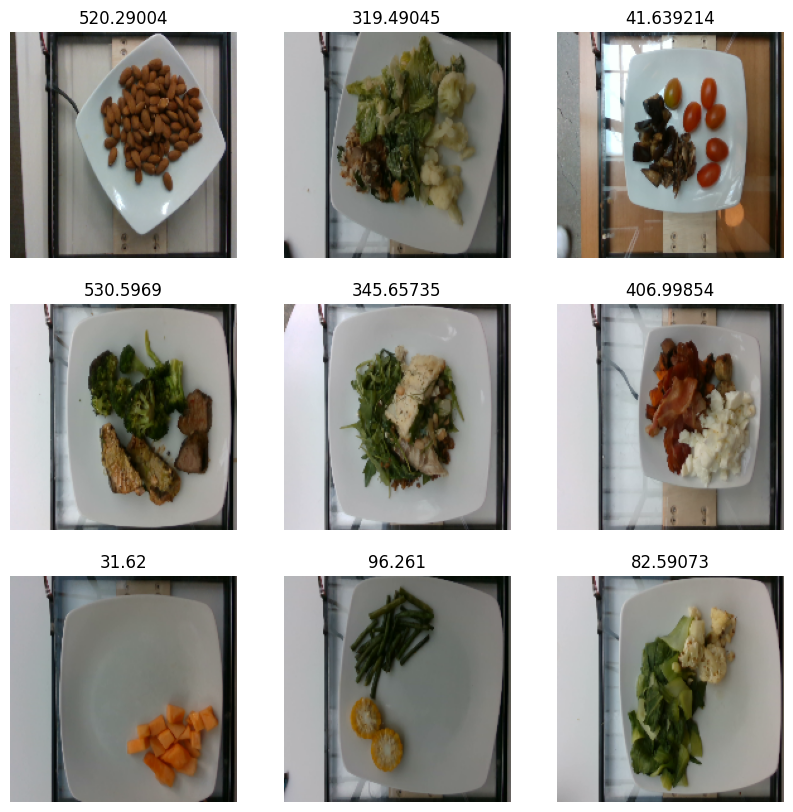

In [63]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(label.numpy()[0]) #preview calories only
  plt.axis("off")

The above images with total calories at the title look like the data has been set-up correctly. Calories visually seem to make sense too. Note that we have other macro info, but are only displaying the calories for this preview.

**Next standardize the data in case missed in preprocessing pipeline**

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here we standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [64]:
# Code fragment in case want to rescale dataset individually, else is covered in
# model defition first layer

# normalization_layer = tf.keras.layers.Rescaling(1./255)
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixel values are now in `[0,1]`.
# print('Check pixel rescaling range 0-1: ', np.min(first_image), np.max(first_image))

In [65]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


## Base CNN Model Definition

In [66]:
num_macros = 5 #(total_calories, total_mass, total_fat, total_carb, total_protein)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255), #rescaling here to sure so that all datasets pass through this
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_macros)
])


In [67]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.mean_squared_error,
  metrics=[tf.keras.metrics.RootMeanSquaredError(), 'mae'])

## Model Fitting and Save Checkpoint

In [68]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
72/72 [==============================] - 192s 2s/step - loss: 17568.8027 - root_mean_squared_error: 132.5473 - mae: 69.0807 - val_loss: 12994.2930 - val_root_mean_squared_error: 113.9925 - val_mae: 64.7644
Epoch 2/10
72/72 [==============================] - 120s 2s/step - loss: 12327.2920 - root_mean_squared_error: 111.0283 - mae: 54.8865 - val_loss: 8559.2002 - val_root_mean_squared_error: 92.5159 - val_mae: 47.3723
Epoch 3/10
72/72 [==============================] - 104s 1s/step - loss: 9941.7373 - root_mean_squared_error: 99.7083 - mae: 46.4970 - val_loss: 8478.3047 - val_root_mean_squared_error: 92.0777 - val_mae: 46.4693
Epoch 4/10
72/72 [==============================] - 113s 2s/step - loss: 9761.0947 - root_mean_squared_error: 98.7983 - mae: 45.8249 - val_loss: 8299.7100 - val_root_mean_squared_error: 91.1027 - val_mae: 46.0784
Epoch 5/10
72/72 [==============================] - 109s 2s/step - loss: 9531.7715 - root_mean_squared_error: 97.6308 - mae: 45.1690 - val_los

In [69]:
#functions to save and load model attempts

# Weights only
#model.save_weights('model/part2_model_weights')
# model.load_weights('model/part2_model_weights')

# Full model
#model.save('model/part2_model')
# model = tf.keras.models.load_model('model/part2_model')

## Test Dataset Results

### Preview 4 predictions and pull images

1/1 [==============================] - 0s 338ms/step


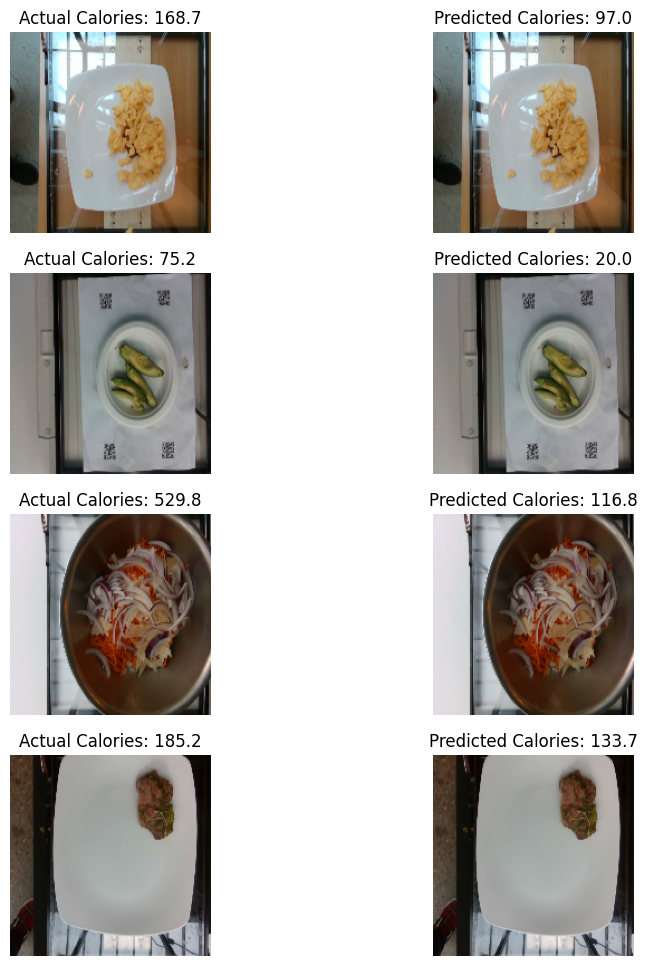

In [70]:
#Test: show sample breakdown of actual v.s. predicted
fig, axs = plt.subplots(4, 2, figsize=(10, 12))
for ax in axs.ravel():
    ax.axis('off')

#(total_calories, total_mass, total_fat, total_carb, total_protein)
test_images = test_ds.take(4)

actual_calories = []
actual_mass = []
actual_fat = []
actual_carb = []
actual_protein = []

pred_calories = []
pred_mass = []
pred_fat = []
pred_carb = []
pred_protein = []

for i, element in enumerate(test_images):
  #actual calories
  axs[i][0].imshow(element[0][0].numpy().astype("uint8"))
  axs[i][0].set_title(f'Actual Calories: {element[1][0][0]:.1f}')
  actual_calories.append(float(element[1][0][0]))
  actual_mass.append(float(element[1][0][1]))
  actual_fat.append(float(element[1][0][2]))
  actual_carb.append(float(element[1][0][3]))
  actual_protein.append(float(element[1][0][4]))

  predicted_macros = model.predict(element)
  predicted_calories = predicted_macros[1][0]
  axs[i][1].imshow(element[0][0].numpy().astype("uint8"))
  axs[i][1].set_title(f'Predicted Calories: {predicted_calories:.1f}')
  pred_calories.append(predicted_macros[1][0])
  pred_mass.append(predicted_macros[1][1])
  pred_fat.append(predicted_macros[1][2])
  pred_carb.append(predicted_macros[1][3])
  pred_protein.append(predicted_macros[1][4])


In [71]:
#look at results for the 4 images randomly taken from test
test_preview = {'actual_calories': actual_calories, 'pred_calories': pred_calories, 'actual_mass': actual_mass, 'pred_mass':pred_mass, 'actual_fat': actual_fat, 'pred_fat': pred_fat, 'actual_carb': actual_carb, 'pred_carb': pred_carb,'actual_protein': actual_protein, 'pred_protein':pred_protein}
test_preview_df = pd.DataFrame(data=test_preview)
test_preview_df

,actual_calories,pred_calories,actual_mass,pred_mass,actual_fat,pred_fat,actual_carb,pred_carb,actual_protein,pred_protein
0,168.720001,96.989632,114.0,85.973053,12.540000,7.866531,1.824000,7.216620,11.400001,7.569383
1,75.200005,19.958363,47.0,41.657169,7.050000,6.486864,4.230000,4.033552,0.940000,-1.196241
2,529.817993,116.818924,457.0,137.617447,29.358000,10.079958,21.484001,8.489218,46.358997,7.377310
3,185.212708,133.656586,88.0,149.071045,10.632797,12.503568,2.611722,7.734900,17.977421,8.309201


In [72]:
full_test_predicted = model.predict(test_ds)

16/16 [==============================] - 7s 443ms/step


In [73]:
full_test_predicted

array([[3.5257422e+02, 3.5960172e+02, 2.0829342e+01, 2.0414297e+01,
        2.9173079e+01],
       [4.3283428e+01, 6.1142563e+01, 4.5866346e+00, 6.0110860e+00,
        3.3413845e-01],
       [4.1504477e+02, 3.7417508e+02, 3.0269688e+01, 3.4781345e+01,
        1.8768513e+01],
       ...,
       [3.4924307e+02, 3.0670572e+02, 2.3707258e+01, 1.4574286e+01,
        2.7958561e+01],
       [1.3713026e+02, 1.2923482e+02, 1.1234880e+01, 1.3662387e+01,
        3.9635811e+00],
       [9.8827080e+01, 9.7054268e+01, 5.8924556e+00, 9.8840437e+00,
        4.0400043e+00]], dtype=float32)

### Look at Full Test Dataset Results

In [74]:
test_elements = test_ds.take(tf.data.experimental.cardinality(val_ds).numpy())

actual_calories = []
actual_mass = []
actual_fat = []
actual_carb = []
actual_protein = []

for i, element in enumerate(test_elements):
  actual_calories.append(float(element[1][0][0]))
  actual_mass.append(float(element[1][0][1]))
  actual_fat.append(float(element[1][0][2]))
  actual_carb.append(float(element[1][0][3]))
  actual_protein.append(float(element[1][0][4]))


In [75]:
full_test_results = {'actual_calories': actual_calories, 'pred_calories': full_test_predicted[:][0], 'actual_mass': actual_mass, 'pred_mass':full_test_predicted[:][1], 'actual_fat': actual_fat, 'pred_fat': full_test_predicted[:][2], 'actual_carb': actual_carb, 'pred_carb': full_test_predicted[:][3],'actual_protein': actual_protein, 'pred_protein':full_test_predicted[:][4]}
full_test_results_df = pd.DataFrame(data=test_preview)
full_test_results_df

,actual_calories,pred_calories,actual_mass,pred_mass,actual_fat,pred_fat,actual_carb,pred_carb,actual_protein,pred_protein
0,168.720001,96.989632,114.0,85.973053,12.540000,7.866531,1.824000,7.216620,11.400001,7.569383
1,75.200005,19.958363,47.0,41.657169,7.050000,6.486864,4.230000,4.033552,0.940000,-1.196241
2,529.817993,116.818924,457.0,137.617447,29.358000,10.079958,21.484001,8.489218,46.358997,7.377310
3,185.212708,133.656586,88.0,149.071045,10.632797,12.503568,2.611722,7.734900,17.977421,8.309201


In [76]:
full_test_results_df['calorie_estimation_difference'] = full_test_results_df.apply(lambda x: abs(x['actual_calories'] - x['pred_calories']), axis=1)
full_test_results_df['mass_estimation_difference'] = full_test_results_df.apply(lambda x: abs(x['actual_mass'] - x['pred_mass']), axis=1)

full_test_results_df['fat_estimation_difference'] = full_test_results_df.apply(lambda x: abs(x['actual_fat'] - x['pred_fat']), axis=1)

full_test_results_df['carb_estimation_difference'] = full_test_results_df.apply(lambda x: abs(x['actual_carb'] - x['pred_carb']), axis=1)

full_test_results_df['protein_estimation_difference'] = full_test_results_df.apply(lambda x: abs(x['actual_protein'] - x['pred_protein']), axis=1)

In [77]:
full_test_results_df.head()

,actual_calories,pred_calories,actual_mass,pred_mass,actual_fat,pred_fat,actual_carb,pred_carb,actual_protein,pred_protein,calorie_estimation_difference,mass_estimation_difference,fat_estimation_difference,carb_estimation_difference,protein_estimation_difference
0,168.720001,96.989632,114.0,85.973053,12.540000,7.866531,1.824000,7.216620,11.400001,7.569383,71.730370,28.026947,4.673469,5.392620,3.830618
1,75.200005,19.958363,47.0,41.657169,7.050000,6.486864,4.230000,4.033552,0.940000,-1.196241,55.241642,5.342831,0.563137,0.196448,2.136241
2,529.817993,116.818924,457.0,137.617447,29.358000,10.079958,21.484001,8.489218,46.358997,7.377310,412.999069,319.382553,19.278042,12.994783,38.981688
3,185.212708,133.656586,88.0,149.071045,10.632797,12.503568,2.611722,7.734900,17.977421,8.309201,51.556122,61.071045,1.870770,5.123178,9.668220


In [78]:
print("average calories off: ",  full_test_results_df.loc[:, 'calorie_estimation_difference'].mean())
print("average mass off (grams): ",  full_test_results_df.loc[:, 'mass_estimation_difference'].mean())
print("average fat off (grams): ", full_test_results_df.loc[:, 'fat_estimation_difference'].mean())
print("average carb off (grams): ", full_test_results_df.loc[:, 'carb_estimation_difference'].mean())
print("average protein off (grams): ", full_test_results_df.loc[:, 'protein_estimation_difference'].mean())

average calories off:  147.8818006515503
average mass off (grams):  103.45584392547607
average fat off (grams):  6.5963544845581055
average carb off (grams):  5.926757425069809
average protein off (grams):  13.654191419482231


In [79]:
full_test_results_df[['calorie_estimation_difference', 'mass_estimation_difference', 'fat_estimation_difference', 'carb_estimation_difference', 'protein_estimation_difference']].describe()

,calorie_estimation_difference,mass_estimation_difference,fat_estimation_difference,carb_estimation_difference,protein_estimation_difference
count,4.000000,4.000000,4.000000,4.000000,4.000000
mean,147.881801,103.455844,6.596354,5.926757,13.654191
std,176.962371,145.758358,8.626578,5.282817,17.190461
min,51.556122,5.342831,0.563137,0.196448,2.136241
25%,54.320262,22.355918,1.543862,3.891496,3.407024
50%,63.486006,44.548996,3.272120,5.257899,6.749419
75%,157.047544,125.648922,8.324612,7.293161,16.996587
max,412.999069,319.382553,19.278042,12.994783,38.981688


Looks like on average for the test set we are 147 calories off with the min at 51 calories and the max at 412 with 75% being 157 calories off or lower. Not bad so far for the base model!